In [1]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import time
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def generate_vector(vector_size: int):
    return np.random.randint(1, 10, size=vector_size, dtype=np.int32)


def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        return result, end_time - start_time

    return wrapper

In [3]:
@timer_decorator
def vector_sum_cpu(vector):
    sum = 0
    for elem in vector:
        sum += elem
    return sum

In [4]:
with open("kernel.cu", "r") as f:
    vector_sum_kernel = f.read()

@timer_decorator
def vector_sum_gpu(vector):
    # Выделение памяти на GPU
    vector_gpu = cuda.mem_alloc(vector.nbytes)
    result_gpu = cuda.mem_alloc(np.int32().nbytes)
    initial_value = np.array([0], dtype=np.int32)

    # Инициализация результата и копирование данных
    cuda.memcpy_htod(result_gpu, initial_value)
    cuda.memcpy_htod(vector_gpu, vector)

    # Компиляция и загрузка CUDA-кода
    mod = SourceModule(vector_sum_kernel)
    vector_sum = mod.get_function("vectorSumKernel")

    # Оптимальные размеры блока и сетки
    block_size = 256
    grid_size = min(32, (len(vector) + block_size - 1) // block_size)  # Ограничиваем максимальное количество блоков

    # Запуск ядра
    vector_sum(result_gpu, vector_gpu, np.int32(len(vector)), 
              block=(block_size, 1, 1), grid=(grid_size, 1))

    # Получение результата
    result = np.empty(1, dtype=np.int32)
    cuda.memcpy_dtoh(result, result_gpu)
    vector_gpu.free()
    result_gpu.free()
    return result[0]

In [5]:
vector_sizes = [1_000, 10_000, 100_000, 500_000, 1_000_000]

In [8]:
array = []

for vector_size in tqdm(vector_sizes):
    vector = generate_vector(vector_size)
    print(f"Размер вектора: {vector_size}")

    time_taken_cpu, time_taken_gpu = 0, 0
    for _ in range(10):
        sum_cpu, iter_time_taken_cpu = vector_sum_cpu(vector)
        time_taken_cpu += iter_time_taken_cpu
        sum_gpu, iter_time_taken_gpu = vector_sum_gpu(vector)
        time_taken_gpu += iter_time_taken_gpu

    time_taken_cpu = np.mean(time_taken_cpu)
    time_taken_gpu = np.mean(time_taken_gpu)

    array.append(
        [
            vector_size,
            time_taken_cpu,
            time_taken_gpu,
            time_taken_cpu / time_taken_gpu,
        ]
    )

df = pd.DataFrame(
    array, columns=["Размер вектора", "Время CPU", "Время GPU", "Ускорение"]
)
df

  0%|          | 0/5 [00:00<?, ?it/s]

Размер вектора: 1000
Размер вектора: 10000
Размер вектора: 100000
Размер вектора: 500000
Размер вектора: 1000000


,Размер вектора,Время CPU,Время GPU,Ускорение
0,1000,0.000000,0.008999,0.000000
1,10000,0.004004,0.008505,0.470761
2,100000,0.050997,0.007003,7.282164
3,500000,0.244831,0.011031,22.194039
4,1000000,0.475004,0.015437,30.769757


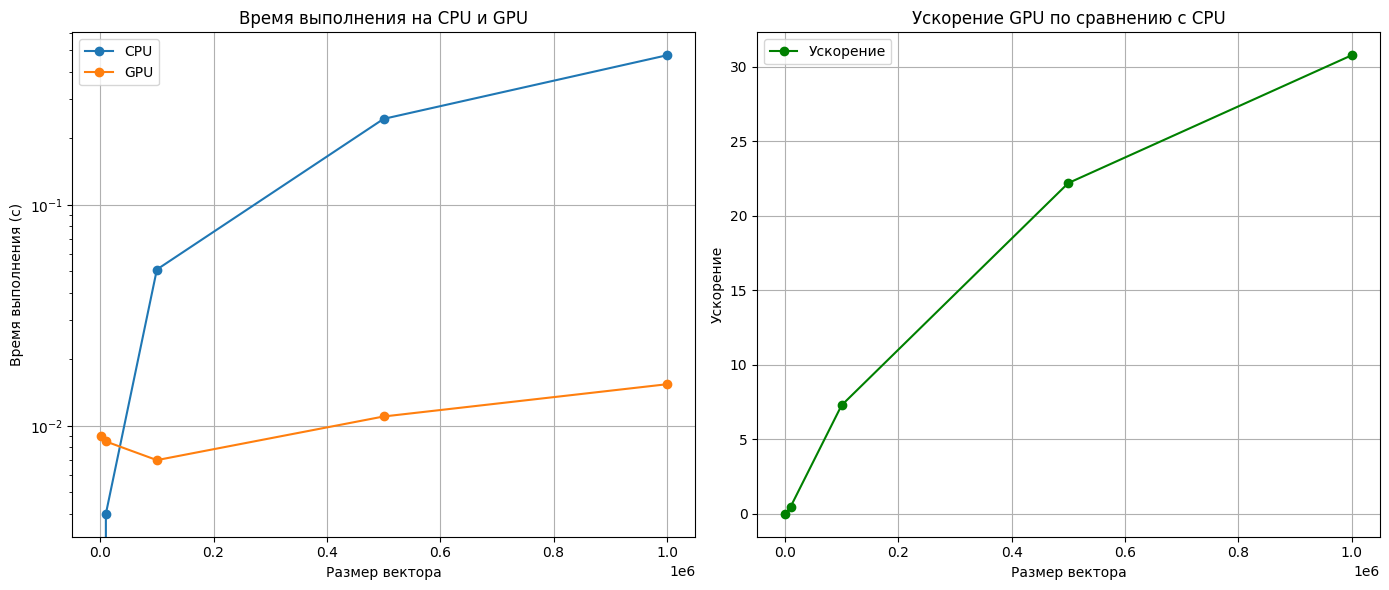

In [9]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(df["Размер вектора"], df["Время CPU"], label="CPU", marker="o")
plt.plot(df["Размер вектора"], df["Время GPU"], label="GPU", marker="o")
plt.xlabel("Размер вектора")
plt.ylabel("Время выполнения (с)")
plt.title("Время выполнения на CPU и GPU")
plt.yscale("log")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(
    df["Размер вектора"], df["Ускорение"], label="Ускорение", marker="o", color="green"
)
plt.xlabel("Размер вектора")
plt.ylabel("Ускорение")
plt.title("Ускорение GPU по сравнению с CPU")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()